# N-gram Language Models: Understanding Context in Language

This lab introduces n-gram language models, a fundamental approach to understanding and predicting text. We'll explore how these models work, their limitations, and why they led to the development of more sophisticated approaches like neural networks and transformers.

## Understanding Language Models: From N-grams to Transformers

Modern Large Language Models like GPT-4 and Claude appear almost magical in their ability to understand and generate human language. However, at their core, these models are attempting to solve the same fundamental challenge that motivated the earliest language models: predicting what word comes next given some context. By starting with N-gram models, we can build an intuitive understanding of this core task while encountering key concepts that remain relevant in today's most advanced models.

### Why Start with N-grams?
N-gram models represent one of the simplest approaches to modeling language: they predict the next word based on a fixed window of previous words. This straightforward approach helps us understand several fundamental concepts:

1. **Context Windows**: Like N-gram models, modern transformers also process text through windows of context, though they do so in a much more sophisticated way. Understanding the limitations of fixed-context windows in N-grams helps explain why mechanisms like attention were revolutionary.

2. **The Sparsity Problem**: As we increase N to capture more context, we quickly run into the problem of data sparsity - many perfectly valid word sequences never appear in our training data. This same challenge motivated the development of neural language models that can generalize beyond exact matches.

3. **Probability Distributions**: N-gram models output probability distributions over possible next words. While modern LLMs use much more complex mechanisms to generate these distributions, the basic idea of modeling language as probability distributions over tokens remains the same.

4. **Evaluation Metrics**: Concepts like perplexity, which we use to evaluate N-gram models, remain relevant for evaluating modern language models. Understanding these metrics helps us grasp what it means for a language model to be "good."

By working through this lab, you'll develop an intuition for these core concepts that will help you better understand how modern language models work. As we progress from simple counting-based N-grams to neural approaches, you'll see how each innovation helps address the limitations of previous approaches while building on the same fundamental principles.


## Setup

First, let's import our required libraries and load our data:

In [1]:
import pandas as pd
import nltk
import seaborn as sns
import string
from nltk.util import ngrams
from nltk.probability import ConditionalFreqDist, ConditionalProbDist, MLEProbDist, FreqDist
import numpy as np
import matplotlib.pyplot as plt

# Download required NLTK data for tokenization
nltk.download('punkt')

# Create a translation table to remove punctuation
translator = str.maketrans('', '', string.punctuation)

[nltk_data] Downloading package punkt to /Users/gizmofo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Load our datasets
`randomized_train` is a set of clinical trial descriptions that contain the word `randomized` in them. We will train ngram language models with this data.

We will test the performance of the ngram language models on heldout data:
`randomized_test` is a different set of clinical trial descriptions that contain the word `randomized` in them. 
`physics_test` is a set of clinical trial descriptions that contain the word `physics` in them.

We should see that when evaluated on heldout data, the ngram language model should be more representative of `randomized_test` than `physics_test`


In [2]:
randomized_train = pd.read_csv('https://www.dropbox.com/scl/fi/rp66akszfxugpavlh8ewy/randomized_train.csv?rlkey=ayx18lr6hdkoawksvynuydcd1&st=cq9a6rx0&dl=1')
randomized_test = pd.read_csv('https://www.dropbox.com/scl/fi/0d0kfhafi3aju5yzejek9/randomized_test.csv?rlkey=vcfvl2vmz85qcenfpx46us9c8&st=iwd2lzws&dl=1')
physics_test = pd.read_csv('https://www.dropbox.com/scl/fi/nat7w9dfkv7om2vsqbh38/physics_test.csv?rlkey=hoe1fzu2a9hr183lbu7a58zqr&st=0npcpsfv&dl=1')

## Understanding N-grams

N-grams are contiguous sequences of n items from a text. In our case, these items will be words. Let's start by preparing our text data and examining unigrams (individual words).

### Preprocess training data.
**Note**: This is fairly basic preprocessing  

In [3]:
def preprocess_text(text):
    # Convert to lowercase and remove short words
    text = text.lower()
    # Only keep words 3 or more characters long
    text = ' '.join([word for word in text.split() if len(word) > 2])
    # Remove punctuation
    text = text.translate(translator)
    return text

First, combine all descriptions into a single text using pandas `str.cat()`

The `sep=' '` parameter adds a space between each description

In [4]:
randomized_text_train = preprocess_text(randomized_train.description.str.cat(sep=' '))

Now do the same for other datasets:

In [5]:
randomized_text_test = preprocess_text(randomized_test.description.str.cat(sep=' '))
physics_text_test = preprocess_text(physics_test.description.str.cat(sep=' '))

Convert our text into a list of tokens (words) using NLTK's tokenizer

This is more sophisticated than just splitting on spaces - it handles contractions, punctuation, and other special cases properly

In [6]:
rand_tokens_train = nltk.word_tokenize(randomized_text_train)
rand_tokens_test = nltk.word_tokenize(randomized_text_test)
physics_tokens_test = nltk.word_tokenize(physics_text_test)

In [7]:
# Let's look at a small sample of our tokens
print("\nFirst 20 tokens:")
print(rand_tokens_train[:20])


First 20 tokens:
['purpose', 'assess', 'the', 'efficacy', 'physical', 'training', 'program', 'patients', 'with', 'ankylosing', 'spondylitis', 'as', 'randomized', 'controlled', 'study', 'introduction', 'osteoporosis', 'and', 'osteopenia', 'are']


In [8]:
# Basic corpus statistics
print("Training corpus size:", len(rand_tokens_train), "tokens")
print("Vocabulary size:", len(set(rand_tokens_train)), "unique words")


Training corpus size: 223812 tokens
Vocabulary size: 19800 unique words


### Now, let's create our language model with specified n-gram size
Step 1: Create a list of ngrams

In [9]:
ngrams_list = list(ngrams(rand_tokens_train, 2))
ngrams_list[:5]

[('purpose', 'assess'),
 ('assess', 'the'),
 ('the', 'efficacy'),
 ('efficacy', 'physical'),
 ('physical', 'training')]

Step 2: Create conditional frequency distribution

For each n-gram, we use all but the last word as the condition



In [10]:
cfd = ConditionalFreqDist((' '.join(gram[:-1]), gram[-1]) for gram in ngrams_list)

`ConditionalFreqDist` is an object that says for each context (in this case a word), how many times other words follow it.

In [11]:
# These are the words that follow 'randomzed' the number of times it happens
cfd['randomized']

FreqDist({'controlled': 594, 'clinical': 189, 'trial': 177, 'phase': 145, 'receive': 118, 'study': 113, 'into': 101, 'control': 75, 'either': 71, '11': 64, ...})

Step 3: Convert to probabilities

Note MLEProbDist is the function that finds the ngram probabilities

In [12]:
cpd = ConditionalProbDist(cfd, MLEProbDist)


In [13]:
# Example: P(control|randomized)
cpd['randomized'].prob('control')


0.029988004798080767

In [14]:
# Look at word frequencies/counts
word_counts = FreqDist(rand_tokens_train)

print("\nMost common words:")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")


Most common words:
the: 13409
and: 8888
will: 4356
with: 3908
for: 2761
patients: 2629
randomized: 2501
study: 2499
this: 2096
treatment: 1529


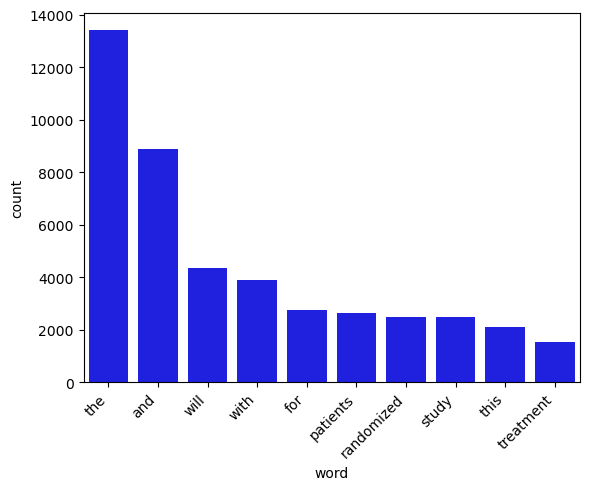

In [15]:
# Plotting most common words using seaborn
most_common = pd.DataFrame(word_counts.most_common(10), columns=['word', 'count'])

ax = sns.barplot(data=most_common, x='word', y='count', color='blue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

### Understanding Word Distributions

Let's examine how word frequencies are distributed in our corpus. This will help us understand the challenge of data sparsity in language modeling.

The big spike at 1 shows that most words in our corpus show up very few times. 

<Axes: xlabel='counts', ylabel='Count'>

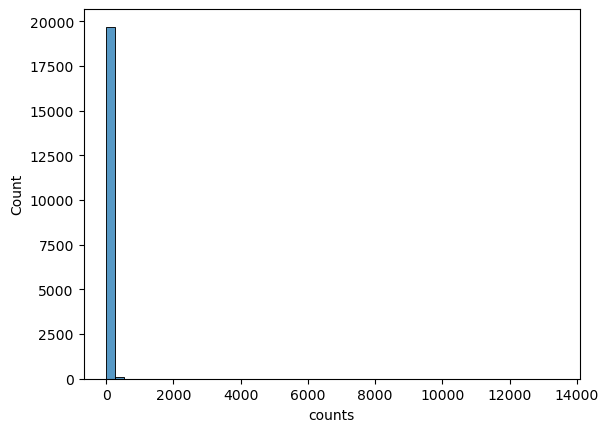

In [16]:
counts = pd.DataFrame(list(word_counts.values()), columns=['counts'])
counts['log_counts'] = np.log10(counts.counts)
sns.histplot(data=counts, x='counts', bins=50)

<Axes: xlabel='log_counts', ylabel='Count'>

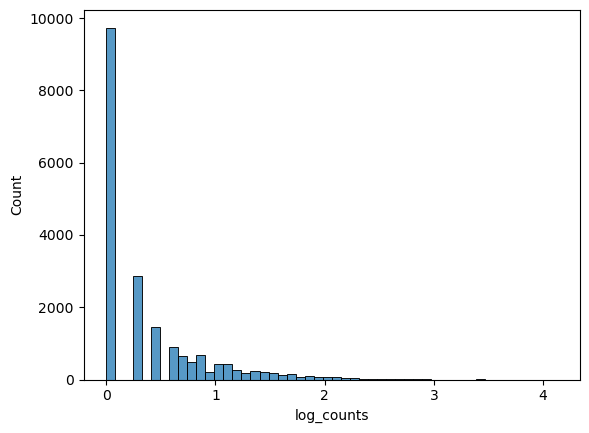

In [17]:
# Same plot with counts logged for visualization purposes
sns.histplot(data=counts, x='log_counts', bins=50)

### Exercise 1: Exploring Context
Try answering these questions using the code we've written (feel free to ask an LLM for help):
1. What are the most common words that follow "control" in our dataset?
2. What percentage of bigrams appear only once?
3. How many unique words follow "the" vs. a less common word like "experiment"?



What are the most common words that follow "control" in our dataset?

In [18]:
# These are the words that follow 'YOUR_WORD' the number of times it happens
cfd['control']

FreqDist({'group': 212, 'trial': 59, 'and': 36, 'arm': 28, 'the': 23, 'condition': 17, 'groups': 13, 'intervention': 8, 'groupthe': 7, 'study': 7, ...})

What percentage of bigrams appear only once?

In [19]:
# Look at word frequencies/counts
bigram_counts = FreqDist(ngrams_list)

print("\nMost common words:")
for word, count in bigram_counts.most_common(10):
    print(f"{word}: {count}")



Most common words:
('patients', 'with'): 770
('this', 'study'): 686
('randomized', 'controlled'): 594
('the', 'study'): 537
('will', 'randomized'): 464
('and', 'the'): 420
('the', 'investigators'): 402
('controlled', 'trial'): 401
('study', 'will'): 342
('patients', 'will'): 332


In [21]:
#thanks claude!

# Get total count of unique bigrams
total_unique_bigrams = len(bigram_counts)

# Count bigrams that appear only once
singles = len([item for item, count in bigram_counts.items() if count == 1])

# Calculate percentage
percentage = (singles / total_unique_bigrams) * 100

print(f"\nTotal unique bigrams: {total_unique_bigrams}")
print(f"Bigrams appearing once: {singles}")
print(f"Percentage of bigrams appearing once: {percentage:.2f}%")


Total unique bigrams: 124248
Bigrams appearing once: 99595
Percentage of bigrams appearing once: 80.16%


How many unique words follow "the" vs. a less common word like "experiment"?

In [24]:
the_counts = cfd['the']
# Count unique words following 'the'
the_followers = cfd['the']
unique_after_the = len(the_followers)
print(f"\nNumber of unique words that follow 'the': {unique_after_the}")
print("\nMost common words following 'the':")
for word, count in the_followers.most_common(5):
    print(f"{word}: {count}")

# Compare with 'experiment'
exp_followers = cfd['experiment']
unique_after_exp = len(exp_followers)
print(f"\nNumber of unique words that follow 'experiment': {unique_after_exp}")
print("\nMost common words following 'experiment':")
for word, count in exp_followers.most_common(5):
    print(f"{word}: {count}")


Number of unique words that follow 'the': 3023

Most common words following 'the':
study: 537
investigators: 402
efficacy: 250
intervention: 224
treatment: 222

Number of unique words that follow 'experiment': 9

Most common words following 'experiment':
will: 2
the: 2
and: 2
with: 1
minimize: 1


In [ ]:
# Recall that we've already created these objects in our lab 
# that you can use to answer these questions:
# cfd: Conditional frequency distribution
# word_counts: Frequency distribution of individual words
# ngrams_list: List of bigrams from our corpus


# Measuring Language Model Quality with Perplexity

Perplexity is a way to evaluate how well our language model predicts text. Lower perplexity means better predictions. Intuitively, if a model is "perplexed" by text, it means it didn't expect those word combinations.

## Evaluating Language Models with Perplexity

Now that we've built our n-gram models, we need a way to evaluate how well they work. The standard metric for evaluating language models is **perplexity**. 

Perplexity tells us how "surprised" or "perplexed" our model is by new text. The lower the perplexity, the better our model is at predicting the text. Here's how it works:

1. For each word in our text, we:
   - Look at the previous n-1 words (the context)
   - Calculate how likely our model thinks the current word is
   - Add this to our running calculation
2. At the end, we take the geometric mean of these probabilities

A few important things to note:
- If our model thinks a word sequence is very likely (high probability), it contributes to lower perplexity
- If our model thinks a word sequence is unlikely (low probability), it contributes to higher perplexity
- If our model has never seen a particular sequence before, it will be very perplexed!

Since we are going to experiment with different context lengths, we'll first create a function that generates a language model given tokens.

In [25]:
def create_ngram_model(tokens, n):
    """
    Creates an n-gram language model from a sequence of tokens.
    
    The model estimates P(word_n | word_1, ..., word_{n-1}) using maximum likelihood estimation:
    P(word_n | context) = count(context, word_n) / count(context)
    
    Parameters:
        tokens: List of tokens from which to build the model
        n: Length of n-gram sequences to consider
    
    Returns:
        ConditionalProbDist object containing the probability distributions
    """
    # Create n-grams from training data
    # Each n-gram is a sequence of n consecutive tokens
    ngrams_list = list(ngrams(tokens, n))
    
    # Create conditional frequency distribution
    # For each n-gram (w1, w2, ..., wn), we use (w1, ..., w{n-1}) as the condition
    # and wn as the word we're trying to predict
    # The resulting cfd maps: context -> {word: count}
    cfd = ConditionalFreqDist(
        (' '.join(gram[:-1]), gram[-1]) 
        for gram in ngrams_list
    )
    
    # Convert raw counts to probabilities using maximum likelihood estimation
    # For each context, P(word|context) = count(context,word) / count(context)
    # MLEProbDist handles this normalization for us
    cpd = ConditionalProbDist(cfd, MLEProbDist)
    
    return cpd

In [26]:
cpd_2 = create_ngram_model(rand_tokens_train, 2)

Then we will create a function that computes perplexity which takes as input:
 - a set of test tokens,
 - the ngram language model created from `create_ngram_model`
 - the value of n in the ngram language model

In [27]:
def perplexity(test_tokens, cpd, n):
    """
    Calculate perplexity of a language model on test data.
    
    Perplexity is defined as: exp(-1/N * sum(log P(w_i|context_i)))
    where N is the number of words and P(w_i|context_i) is the model's
    predicted probability of word w_i given its context.
    
    Lower perplexity means the model is less "surprised" by the test data,
    indicating better predictions.
    
    Parameters:
        test_tokens: List of tokens to evaluate on
        cpd: Conditional probability distribution from training
        n: Size of n-grams used in the model
    
    Returns:
        float: Perplexity score (lower is better)
    """
    # Create n-grams from test data
    test_ngrams = list(ngrams(test_tokens, n))
    N = len(test_ngrams)
    log_prob_sum = 0
    
    # Keep track of problematic sequences for analysis
    worst_sequences = []
    
    for ngram in test_ngrams:
        # Split into context and word to predict
        context = ' '.join(ngram[:-1])  # Previous n-1 words
        word = ngram[-1]                # Word to predict
        
        try:
            # Get model's predicted probability P(word|context)
            prob = cpd[context].prob(word)
            
            if prob == 0:
                # Handle zero probabilities by assigning a small value
                # This prevents log(0) which would be undefined
                # 1e-7 is a form of smoothing to handle unseen sequences
                prob = 1e-7
                worst_sequences.append((ngram, prob))
        except:
            # Handle cases where we haven't seen this context before
            prob = 1e-7
            worst_sequences.append((ngram, prob))
            
        # Add log probability to our running sum
        # We use log probabilities to prevent numerical underflow
        # when multiplying many small probabilities
        log_prob_sum += np.log(prob)
    
    # Calculate final perplexity:
    # exp(-1/N * sum(log P(w_i|context_i)))
    return np.exp(-log_prob_sum / N)

In [28]:
# Let's calculate perplexity on our different datasets
print("Perplexity on training data:", perplexity(rand_tokens_train, cpd_2, 2))
print("Perplexity on test data (same domain):", perplexity(rand_tokens_test, cpd_2, 2))
print("Perplexity on physics data (different domain):", perplexity(physics_tokens_test, cpd_2, 2))

Perplexity on training data: 34.09545368814962
Perplexity on test data (same domain): 15263.17518121725
Perplexity on physics data (different domain): 61007.22594605268


Now let's see what happens when we use a trigram language model (n=3)


In [29]:
# First create the model on training data
cpd_3 = create_ngram_model(rand_tokens_train, 3)

Then evaluate on our three sets (train, test from same distribution, test from different distribution)

In [30]:
# Let's calculate perplexity on our different datasets
print("Perplexity on training data:", perplexity(rand_tokens_train, cpd_3, 3))
print("Perplexity on test data (same domain):", perplexity(rand_tokens_test, cpd_3, 3))
print("Perplexity on physics data (different domain):", perplexity(physics_tokens_test, cpd_3, 3))

Perplexity on training data: 2.67105611586623
Perplexity on test data (same domain): 420268.21799560654
Perplexity on physics data (different domain): 2051104.5896776929


### Exercise 2: Perplexity and sparsity
Now create a language model with n=4 and evaluate on our various datasets. 

- Explain why perplexity on the training set goes down as we increase n
- Why does perplexity go up on BOTH of the test sets, even the one from the same distribution?

# From Counting to Learning: Moving Beyond N-grams

Our exploration of N-gram models has revealed some fundamental challenges in modeling language. Let's examine why these limitations lead us naturally toward machine learning approaches.

## The Limitations of Counting

Through our experiments with N-grams, we've encountered three key challenges:

First, we saw how increasing N to capture more context leads to severe data sparsity. When we moved from bigrams to trigrams, our perplexity on test data increased dramatically. This happened because many legitimate word sequences in our test data never appeared in our training set --- we simply can't observe every possible combination of words.

Second, N-gram models have no way to recognize similar contexts. Consider these phrases from clinical trials:
- "patients were randomly assigned to"
- "subjects were randomly allocated to"
These convey the same meaning, but our N-gram model treats them as completely different sequences. It can't recognize that "patients" and "subjects" play similar roles, or that "assigned" and "allocated" are nearly synonymous in this context.

Third, N-gram models are extremely rigid in their use of context. A bigram model looking at "The patient was" can only use "was" to predict the next word, even though "patient" might be more informative in this case. We need a more flexible way to use context.

## Why Machine Learning Helps

Machine learning approaches, starting with the simple logistic regression model we'll explore next, help address these limitations in several ways:

1. Parameter Sharing: Instead of treating each word sequence as unique, machine learning models can learn patterns that generalize across similar contexts. They might learn, for example, that words following "randomly" tend to be similar regardless of what came before.

2. Feature-Based Representation: By representing words as features rather than atomic units, we can capture similarities between different contexts. This helps our model generalize to sequences it hasn't seen exactly during training.

3. Learnable Context Usage: Rather than using a fixed context window, machine learning models can learn which parts of the context are most important for prediction. This flexibility helps them make better use of available information.

## A Simple First Step: Logistic Regression

We'll begin our exploration of machine learning approaches with logistic regression - one of the simplest machine learning models. While it won't solve most of the problems we've identified, it will help us understand how moving from counting to learning can improve our language models.

Let's start by focusing on a specific prediction task: given a word, predict whether it will be followed by "controlled" (a key word in clinical trials). This simplified task will let us clearly see how machine learning differs from our N-gram approach.



In [31]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.feature_extraction.text import CountVectorizer


In [32]:
# First, let's look at our baseline from n-grams
print("N-gram probability of 'controlled' following 'randomized':")
print(cpd['randomized'].prob('controlled'))

N-gram probability of 'controlled' following 'randomized':
0.2375049980007997


Now let's frame this as a binary classification problem
For each word in our corpus, we'll create a feature indicating if it predicts 'controlled'

In [33]:
# Create training data
bigrams_for_logistic = [bigram[0] for bigram in ngrams_list]  # First word of each bigram
y = [1 if bigram[1]=='controlled' else 0 for bigram in ngrams_list]  # Is second word 'controlled'?
        

In the code below, the vectorizer creates a sparse matrix X where:
- Each row represents a word (the context)
- Each column represents a feature (presence/absence of words)
- X[i,j] = 1 if word j appears in context i, 0 otherwise

This converts our text prediction problem into a standard classification task:
- Input: Feature vector representing the current word
- Output: Probability distribution over possible next words (in this case, `controlled` or not `controlled`)

In [34]:
# Convert words to features using bag-of-words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(bigrams_for_logistic)

In [35]:
print("\nFeature matrix shape:", X.shape)
print("Number of unique words (features):", len(vectorizer.get_feature_names_out()))


Feature matrix shape: (223811, 19692)
Number of unique words (features): 19692


In [36]:
# Train logistic regression model
clf = lr(n_jobs=10)
clf.fit(X, y)

LogisticRegression(n_jobs=10)

In [37]:
# Let's examine predictions for specific words
test_words = ["randomized", "random", "the", "study", "patients"]
X_test = vectorizer.transform(test_words)
predictions = clf.predict_proba(X_test)[:, 1]
predictions

array([2.34965865e-01, 5.38680604e-04, 1.15498180e-04, 6.99539925e-04,
       2.68306456e-04])

In [38]:
print("\nProbability of 'controlled' following:")
for word, prob in zip(test_words, predictions):
    
    print(f"From logistic regression model: {word}: {prob:.3f}")
    print(f"From bigram language model: {word}: {cpd[word].prob('controlled'):.3f}")
    print('===========')


Probability of 'controlled' following:
From logistic regression model: randomized: 0.235
From bigram language model: randomized: 0.238
From logistic regression model: random: 0.001
From bigram language model: random: 0.000
From logistic regression model: the: 0.000
From bigram language model: the: 0.000
From logistic regression model: study: 0.001
From bigram language model: study: 0.001
From logistic regression model: patients: 0.000
From bigram language model: patients: 0.000


### Multinomial regression

The logistic regression model generates probabilities that are very similar to the ones from the bigram language model --- which is what we want. However, it does this without resorting to simple counting. It does this via optimizing an objective function -- we'll talk more about this in the next class.  

Predicting just 'controlled' is limiting. Let's extend this to predict
the full distribution over possible next words using multinomial logistic regression.

In the process we'll see that even this approach is computationally expensive.

In [39]:
# Filter to more common words to make computation manageable
min_freq = 500
filtered_tokens = [t for t in rand_tokens_train if word_counts[t] >= min_freq]
print(f"\nVocabulary size after filtering (freq >= {min_freq}):", 
      len(set(filtered_tokens)))


Vocabulary size after filtering (freq >= 500): 30


In [40]:
# Create training data for multinomial model
bigrams_filtered = list(ngrams(filtered_tokens, 2))
X_words = [bigram[0] for bigram in bigrams_filtered]
y_next = [bigram[1] for bigram in bigrams_filtered]

**Note**: `y_next` is no longer a vector of just 0s and 1s, but is now a list of words.

In [41]:
y[:20] # outcome for logistic regression where 1 means controlled follows randomized

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [42]:
y_next[:20] # outcome for multinomial logistic regression

['patients',
 'with',
 'randomized',
 'controlled',
 'study',
 'and',
 'are',
 'and',
 'are',
 'for',
 'and',
 'the',
 'the',
 'with',
 'are',
 'and',
 'the',
 'and',
 'and',
 'the']

In [43]:
# Convert to features
vectorizer_multi = CountVectorizer()
X_filtered = vectorizer_multi.fit_transform(X_words)

In [44]:
# Train multinomial model
clf_multi = lr(multi_class='multinomial', n_jobs=10, max_iter=500)
clf_multi.fit(X_filtered, y_next)

LogisticRegression(max_iter=500, multi_class='multinomial', n_jobs=10)

In [46]:
def compare_distributions(word, cpd, multi_model, vectorizer, top_k=10):
    """
    Compares how N-gram and multinomial logistic regression models predict
    the next word distribution.
    
    This function visualizes the differences between:
    1. Simple counting-based N-gram probabilities
    2. Learned probabilities from the multinomial model
    
    The comparison helps us understand how moving beyond simple counting
    affects our probability estimates.
    
    Parameters:
        word: String - The context word whose following distribution we want to examine
        cpd: ConditionalProbDist - N-gram model containing count-based probabilities
        multi_model: LogisticRegression - Trained multinomial model
        vectorizer: CountVectorizer - Fitted vectorizer for processing input words
        top_k: int - Number of top predictions to compare (default: 10)
    
    Returns:
        None - Displays a plot comparing the distributions
    """
    try:
        # First, get the N-gram based probability distribution
        # cpd[word] gives us the probability distribution for words following our target word
        # .samples() returns all words that ever followed our target word in training
        vocab = cpd[word].samples()
        
        # Calculate probability for each possible next word according to N-gram model
        # This is based on simple counting: P(next|word) = count(word,next)/count(word)
        ngram_probs = [cpd[word].prob(w) for w in vocab]
        
        # Now get predictions from our multinomial model
        # First transform our word into the feature representation expected by the model
        # This creates a sparse vector where each position represents a word in our vocabulary
        X_pred = vectorizer.transform([word])
        
        # Get probability distribution over all possible next words
        # The model uses learned weights to convert word features into probabilities
        # predict_proba returns a matrix; we want the first (only) row
        model_probs = multi_model.predict_proba(X_pred)[0]
        
        # Sort both distributions by probability and take top k
        # zip combines words with their probabilities
        # sorted with reverse=True gives highest probabilities first
        ngram_top = sorted(zip(vocab, ngram_probs), 
                          key=lambda x: x[1], reverse=True)[:top_k]
        model_top = sorted(zip(multi_model.classes_, model_probs), 
                          key=lambda x: x[1], reverse=True)[:top_k]
        
        # Convert to DataFrames for plotting
        # We create separate DataFrames for each model and mark their source
        # This lets us plot them side by side for comparison
        ngram_df = pd.DataFrame({
            'word': [w for w, _ in ngram_top],
            'probability': [p for _, p in ngram_top],
            'model': ['N-gram'] * top_k  # Label these points as coming from N-gram model
        })
        
        model_df = pd.DataFrame({
            'word': [w for w, _ in model_top],
            'probability': [p for _, p in model_top],
            'model': ['Multinomial'] * top_k  # Label these points as coming from multinomial model
        })
        
        # Combine into single DataFrame for plotting
        # concat vertically stacks the DataFrames, keeping all columns
        plot_df = pd.concat([ngram_df, model_df])
        
        # Create a grouped bar plot comparing the distributions
        # figsize=(15, 6) makes the plot wide enough to read all labels
        plt.figure(figsize=(15, 6))
        g = sns.barplot(data=plot_df, x='word', y='probability', hue='model')
        
        # Rotate labels for readability
        # ha='right' aligns the rotated labels with their bars
        g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
        
        plt.title(f'Top {top_k} Words Following "{word}"')
        plt.tight_layout()  # Adjust spacing to prevent label cutoff
    
    except Exception as e:
        # If anything goes wrong (e.g., word not in vocabulary),
        # print informative error message
        print(f"'{word}' not found or other error occurred: {str(e)}")

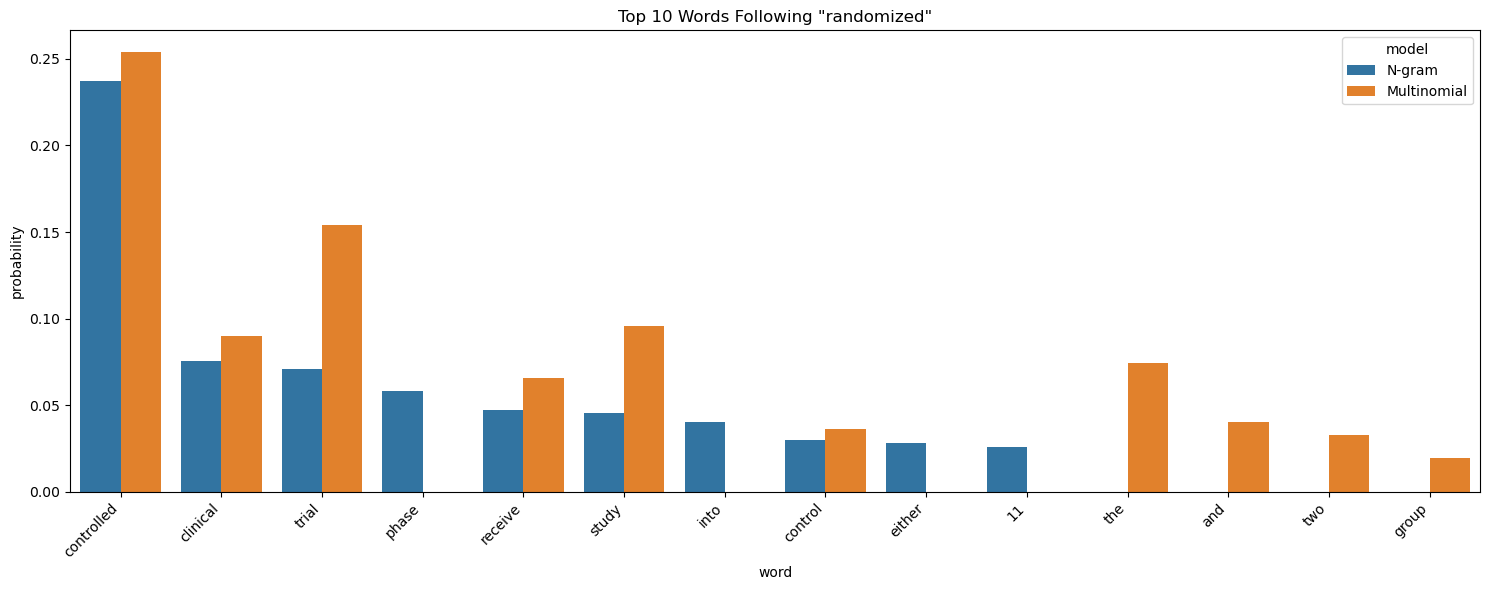

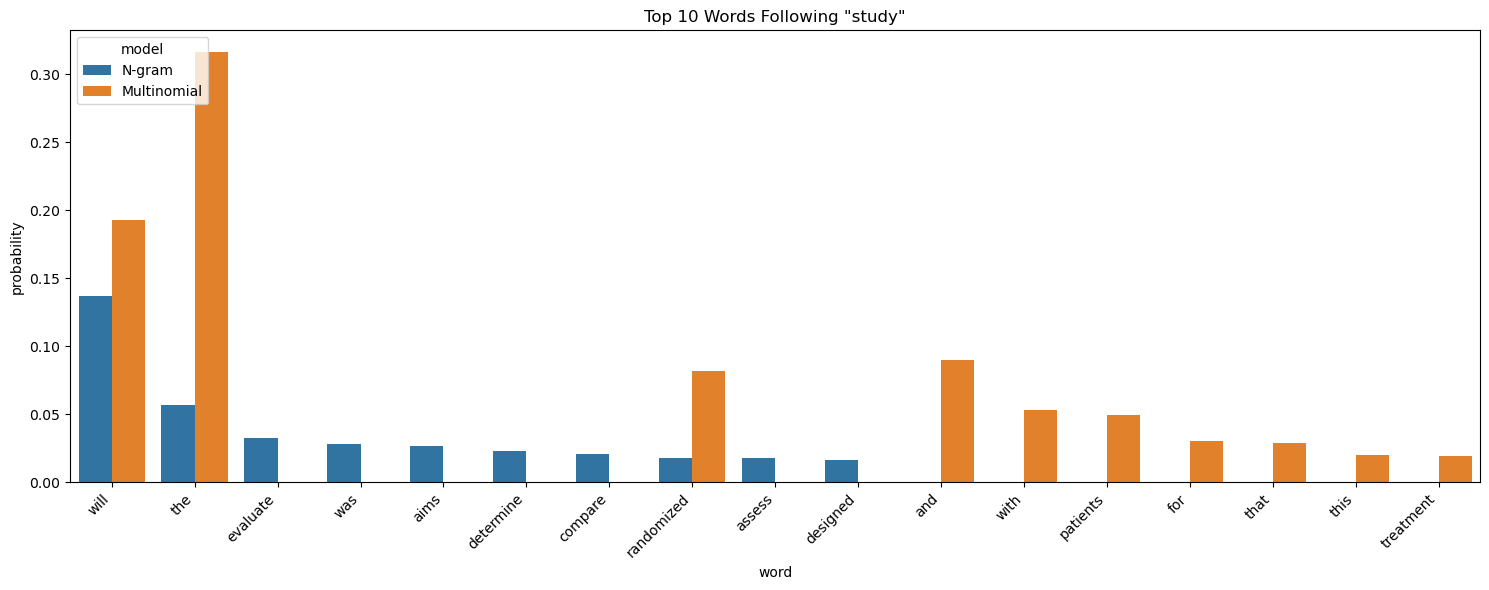

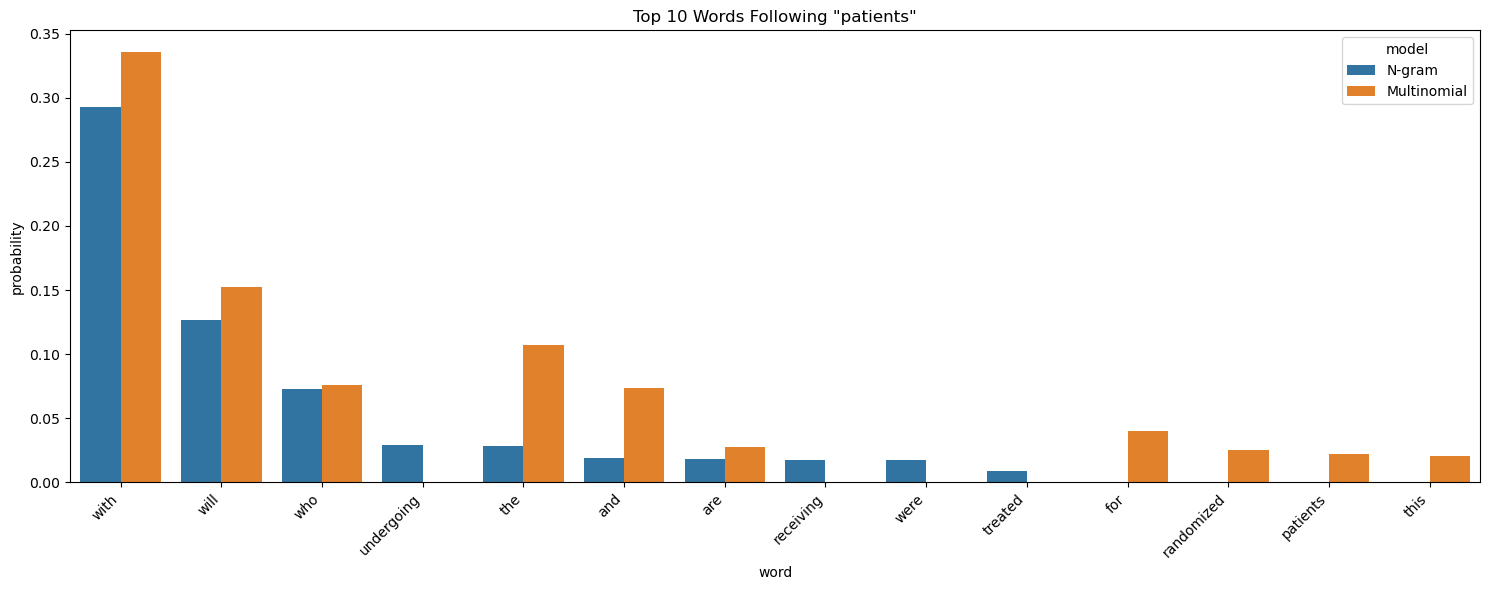

In [47]:
# Compare distributions for interesting words
for word in ['randomized', 'study', 'patients']:
    compare_distributions(word, cpd, clf_multi, vectorizer_multi)

We see bigger differences between the multionomial model and the ngram language model here. This is  driven by the fact that we dropped a bunch of words for the multinomial model but are using the ngram model that was based on all words. 

### Exercise 3: Standardizing the vocabulary
To test this, create a new ngram language model that uses the same filtered vocabulary as the multinomial logistic model. And then call `compare_distributions` in the same way as above (just make sure to replace the old langauge model w/ the updated one that you created)

In [ ]:
# Hint, you want something like this to create the ngram model
# cpd_filtered_2 = create_ngram_model(xxx, xxx)
# just fillin the xxxs 

